In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

# Misc.
import warnings
warnings.filterwarnings('ignore')

#Set important constants
max_len = 512 # max number of tokens from each tweet

In [2]:
torch.multiprocessing.set_start_method('spawn')
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
data = pd.read_csv("bigbig1000.csv", on_bad_lines='skip')

data.drop(['Unnamed: 0','created_utc','score'], axis=1,inplace=True)

ds = pd.read_csv("bignegative.csv", on_bad_lines='skip')

data.drop_duplicates(inplace=True)

ds.drop(['Unnamed: 0','created_utc','score'], axis=1,inplace=True)

ds.drop_duplicates(inplace=True)

ds = ds[ds['author'] != 'AutoModerator']
ds = ds[~ds['author'].isin(ds[(ds['subreddit']=='Anxiety') | (ds['subreddit'] == 'depression')]['author'].unique())]

data['label'] = 1
ds['label'] = 0

ds= ds[0:len(data)]

df = pd.concat([data,ds])

In [6]:
df

,author,selftext,title,is_submitter,subreddit,label
0,Flat_Mission_2375,I go through what i call cycles where I feel l...,I feel alone,True,Anxiety,1
1,Flat_Mission_2375,I am really proud of you!,Finally showered,False,OCD,1
2,Flat_Mission_2375,The situation is sad because it was 10 years o...,Simran,False,SweetBobbyPodcast,1
3,Flat_Mission_2375,Agreed!,What would you do ?,False,SweetBobbyPodcast,1
4,Flat_Mission_2375,I’m trying 4 weeks right now…it’s been 2 days ...,How long are your tolerance breaks?,False,trees,1
...,...,...,...,...,...,...
23227,Leather-Ad8111,wait this is really scary 😭😭,ISAIAH HUMS DURING THOROUGHFARE??,False,Ethelcain,0
23228,Leather-Ad8111,😭😭😭,her hair,False,Ethelcain,0
23229,Leather-Ad8111,😭😭😭,Strangers- Wii sports,True,Ethelcain,0
23230,Leather-Ad8111,THANK YOU SO MUCH!!,Strangers- Wii sports,True,Ethelcain,0


In [10]:
class_names = ['not anxious', 'anxious']

# Set the model name
model_name = 'prajjwal1/bert-tiny'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name, force_download=True)



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [6]:
#train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

batch_size = 16

# row # must be multiple of batch_size
df_train = df_train[:(len(df_train) // batch_size) * batch_size]
df_val = df_val[:(len(df_val) // batch_size) * batch_size]
df_test = df_test[:(len(df_test) // batch_size) * batch_size]

In [7]:
from Dataset import TextDataset


#creates the dataloader which is used to tokenize and order the data for training
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TextDataset(
        reviews=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=8
    )

In [8]:
train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

#create dataloader for each dataframe

In [9]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return torch.sigmoid(self.out(output))

In [10]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [11]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [12]:
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")  # only use cuda for training

In [13]:
# Number of iterations
EPOCHS = 20

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
'''
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
'''
scheduler = OneCycleLR(optimizer, max_lr = 1e-4, total_steps = total_steps)
# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [14]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        outputs = torch.reshape(outputs, (-1, 1)).float()
        targets = torch.reshape(targets, (-1, 1)).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs.round() == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)


In [15]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            outputs = torch.round(torch.reshape(outputs, (-1, 1)).float())
            targets = torch.reshape(targets, (-1, 1)).float()

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs == targets)
            losses.append(loss.item())

            if progress_bar:
                progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
%%time


from tqdm import tqdm

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)


    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")


    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/20
----------


Training: 100%|█████████████████████████████████████████████████████████████████████| 1997/1997 [00:53<00:00, 49.81it/s]

Train loss 0.027155728343265965 accuracy 0.9939283925888832


Validation:  96%|█████████████████████████████████████████████████████████████████▌  | 240/249 [00:13<00:00, 127.93it/s]

Val   loss 0.8032128514056225 accuracy 0.9919678714859437

Epoch 2/20
----------


Training:  48%|█████████████████████████████████▉                                    | 968/1997 [00:32<00:20, 50.54it/s]Process Process-74:
Process Process-73:
Process Process-75:
Process Process-71:
Process Process-69:
Process Process-72:
Process Process-70:
Process Process-68:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa28e8cb4c0>
Traceback (most recent call last):
  File "/home/kbliu/anaconda3/envs/MyEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/kbliu/anaconda3/envs/MyEnv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/kbliu/anaconda3/envs/MyEnv/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kbliu/anaconda3/envs/MyEnv/lib/python3.12/multiprocessing/popen_f

KeyboardInterrupt: 

In [14]:
# Plot training and validation accuracy 
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

NameError: name 'history' is not defined

In [18]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.842741935483871

In [18]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = [x.to(device) for x in d["input_ids"]]
            attention_mask = [x.to(device) for x in d["attention_mask"]]
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.flatten(outputs.round())

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [19]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [20]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.84      0.85      0.85       252
    depressed       0.85      0.84      0.84       244

     accuracy                           0.84       496
    macro avg       0.84      0.84      0.84       496
 weighted avg       0.84      0.84      0.84       496



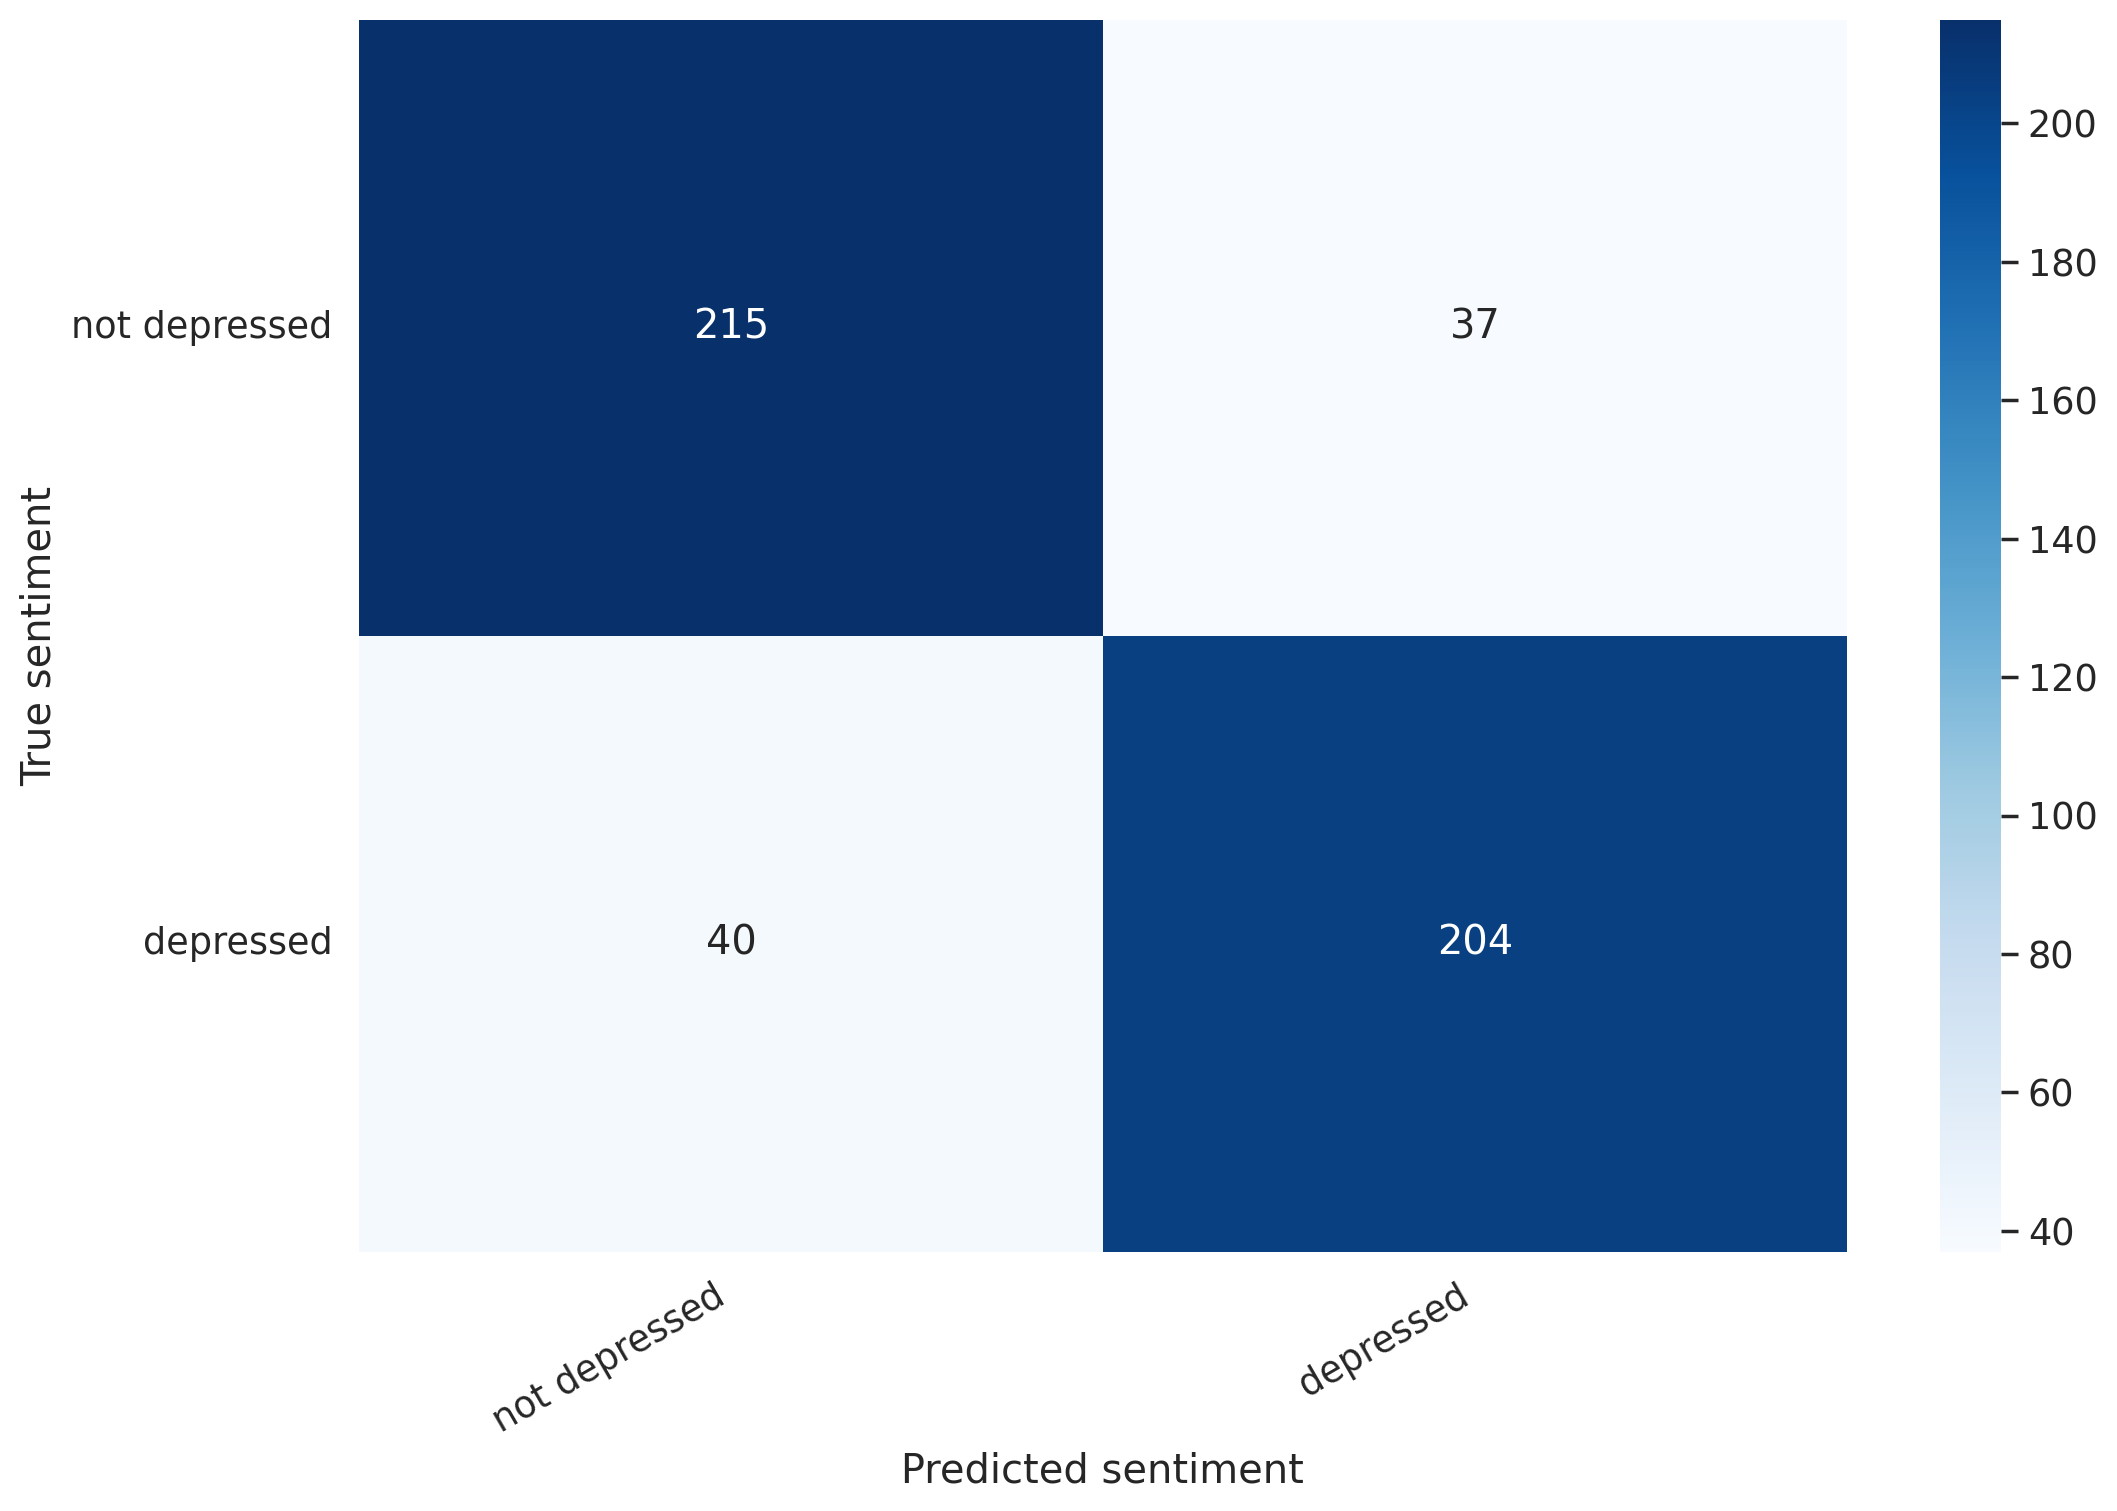

In [21]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [19]:
torch.save(model.state_dict(), "2.pt")

In [22]:
m = SentimentClassifier(2)
m.load_state_dict(torch.load("best_model_state.bin"))
m.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, element

In [23]:
test_acc, _ = eval_model(
  m,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8608870967741935

In [22]:

test = torch.load("2.pt", map_location=torch.device('cuda'))

In [23]:
m = SentimentClassifier(len(class_names))
m.load_state_dict(test)
m = m.to(device)

In [24]:
test_acc, _ = eval_model(
  m,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.5080645161290323

In [38]:
review_text = "anxiety"
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=max_len,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {output[0][0]}')

Review text: anxiety
Sentiment  : 0.999841570854187


In [33]:
df[df['label']==1].iloc[0]['text']

"I can always feel my heartbeat 18M, physically fit\nI'm just wondering if this is normal or what? I do have anxiety so l feel like that has something to do with it. I constantly feel my heartbeat and l only stop feeling it when I distract myself by doing things such as scratching my leg or clenching my calf. Should l be worried about this? It's more of something that's annoying to deal with during day to day life than anything. No pain or anything but I do sometimes get muscle twitches in the left side of my chest.\nIf anyone else has/had a similar feeling, how did you deal with it?\nThanks"